# Meta-Labeling for bet side and size

Implementation of Triple-barrier method for determining side and Meta-labeling for size of the bet. Meta-labeling is a technique introduced by Marco Lopez De Prado in Advances to Financial machine learning.

## Imports

In [89]:
%load_ext autoreload
%autoreload 2

# standard imports
from pathlib import PurePath, Path 
import sys
import time
from collections import OrderedDict as od 
import re 
import os 
import json 

# scientific stack
import pandas as pd 
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import math
import mlfinlab as ml
import sklearn as sk
import pyfolio as pf

# visual tools and plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Dataset

In [90]:
# read in and store raw tick data in pandas dataframe to be cleaned and transformed
raw_tick_data = pd.read_csv('data_ema_imbalance_bar.csv')
raw_tick_data['date_time'] = pd.to_datetime(raw_tick_data.date_time)
raw_tick_data.set_index('date_time', drop=True, inplace=True)
print(raw_tick_data)

                         tick_num     open     high      low    close  \
date_time                                                               
2011-09-21 18:38:24.208      2000  53658.0  64534.0  53543.0  59436.0   
2011-09-21 18:49:54.927      2002  59364.0  59364.0  59279.0  59279.0   
2011-09-21 19:02:50.666      2004  59259.0  59259.0  59251.0  59251.0   
2011-09-21 19:29:51.803      2008  59281.0  59333.0  59046.0  59333.0   
2011-09-21 19:34:52.566      2009  59475.0  59475.0  59475.0  59475.0   
...                           ...      ...      ...      ...      ...   
2012-05-22 20:00:01.170      8196  53237.0  53237.0  53237.0  53237.0   
2012-05-22 20:07:09.216      8197  53223.0  53223.0  53223.0  53223.0   
2012-05-22 23:40:21.646      8198  53277.0  53277.0  53277.0  53277.0   
2012-05-23 06:08:09.305      8199  53477.0  53477.0  53477.0  53477.0   
2012-05-23 07:54:15.303      8200  53407.0  53407.0  53407.0  53407.0   

                             volume     cum_vol  c

## Create Dollar Bars

Here we transform the raw ohlc data into various financial data structures that provide a better representation of the movement of trade information throughout the market.  These bars include: dollar, tick, and volume bars.

## Fitting the Primary Model

This is is the primary model that we will use to drive our strategy (EMA Crossover)

In [91]:
fast_window = 12
slow_window = 26

raw_tick_data['fast_mavg'] = raw_tick_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_tick_data['slow_mavg'] = raw_tick_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()

### Compute side

In [92]:
raw_tick_data['side'] = np.nan
long_signals = raw_tick_data['fast_mavg'] >= raw_tick_data['slow_mavg']
short_signals = raw_tick_data['fast_mavg'] < raw_tick_data['slow_mavg']
raw_tick_data.loc[long_signals, 'side'] = 1
raw_tick_data.loc[short_signals, 'side'] = -1
data = raw_tick_data.dropna()
raw_data = data.copy()
print(long_signals)

date_time
2011-09-21 18:38:24.208    False
2011-09-21 18:49:54.927    False
2011-09-21 19:02:50.666    False
2011-09-21 19:29:51.803    False
2011-09-21 19:34:52.566    False
                           ...  
2012-05-22 20:00:01.170     True
2012-05-22 20:07:09.216     True
2012-05-22 23:40:21.646     True
2012-05-23 06:08:09.305     True
2012-05-23 07:54:15.303     True
Length: 6196, dtype: bool


In [93]:
# set daily volatility
daily_vol = ml.util.get_daily_vol(close=data['close'], lookback=50)
print(daily_vol)

date_time
2011-09-23 13:01:29.218         NaN
2011-09-23 13:09:25.468    0.005339
2011-09-23 13:28:02.497    0.003936
2011-09-23 13:34:15.402    0.003494
2011-09-23 13:38:09.205    0.003027
                             ...   
2012-05-22 20:00:01.170    0.007705
2012-05-22 20:07:09.216    0.007604
2012-05-22 23:40:21.646    0.007461
2012-05-23 06:08:09.305    0.007657
2012-05-23 07:54:15.303    0.007785
Name: close, Length: 6094, dtype: float64


In [94]:
# convert from daily vol to hourly vol (since our data in hourly)
trading_hours_in_day = 8
trading_days_in_year = 252
hourly_vol = daily_vol / math.sqrt(trading_hours_in_day * trading_days_in_year)
hourly_vol_mean = hourly_vol.mean()
print(hourly_vol)

date_time
2011-09-23 13:01:29.218         NaN
2011-09-23 13:09:25.468    0.000119
2011-09-23 13:28:02.497    0.000088
2011-09-23 13:34:15.402    0.000078
2011-09-23 13:38:09.205    0.000067
                             ...   
2012-05-22 20:00:01.170    0.000172
2012-05-22 20:07:09.216    0.000169
2012-05-22 23:40:21.646    0.000166
2012-05-23 06:08:09.305    0.000171
2012-05-23 07:54:15.303    0.000173
Name: close, Length: 6094, dtype: float64


### Apply CUSUM Filter

The purpose of the CUSUM filter is to locate instances of change detection.  These are points that will later be used as t_events for the Triple-barrier method.

In [95]:
# apply symetric CUSUM filter and get timestamps for events
cusum_events = ml.filters.cusum_filter(data['close'], threshold=hourly_vol_mean * 0.5)
cusum_events

DatetimeIndex(['2011-09-22 12:54:02.776000', '2011-09-22 13:12:34.514000',
               '2011-09-22 13:30:10.962000', '2011-09-22 13:34:54.287000',
               '2011-09-22 13:39:39.989000', '2011-09-22 13:42:07.098000',
               '2011-09-22 13:46:03.385000', '2011-09-22 13:51:15.392000',
               '2011-09-22 13:55:12.101000', '2011-09-22 14:00:18.337000',
               ...
               '2012-05-22 19:42:56.944000', '2012-05-22 19:47:14.582000',
               '2012-05-22 19:51:14.477000', '2012-05-22 19:54:38.899000',
               '2012-05-22 19:58:30.729000', '2012-05-22 20:00:01.170000',
               '2012-05-22 20:07:09.216000', '2012-05-22 23:40:21.646000',
               '2012-05-23 06:08:09.305000', '2012-05-23 07:54:15.303000'],
              dtype='datetime64[ns]', length=5874, freq=None)

In [96]:
# compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)
vertical_barriers

2011-09-22 12:54:02.776   2011-09-23 13:01:29.218
2011-09-22 13:12:34.514   2011-09-23 13:28:02.497
2011-09-22 13:30:10.962   2011-09-23 13:34:15.402
2011-09-22 13:34:54.287   2011-09-23 13:38:09.205
2011-09-22 13:39:39.989   2011-09-23 13:42:12.322
                                    ...          
2012-05-21 19:59:06.380   2012-05-22 20:00:01.170
2012-05-21 20:00:33.945   2012-05-22 20:07:09.216
2012-05-21 20:11:48.745   2012-05-22 23:40:21.646
2012-05-22 00:02:28.930   2012-05-23 06:08:09.305
2012-05-22 07:18:47.002   2012-05-23 07:54:15.303
Name: date_time, Length: 5827, dtype: datetime64[ns]

### Set Take Profit and Stop Loss

In [97]:
pt_sl = [1,2]
min_ret = 0.005

### Get Triple-barrier Events using CUSUM filter

In [98]:
triple_barrier_events = ml.labeling.get_events(close=data['close'],
                                                t_events=cusum_events,
                                                pt_sl=pt_sl,
                                                #check between hourly and daily vol
                                                target=daily_vol,
                                                min_ret=min_ret,
                                                num_threads=3,
                                                vertical_barrier_times=vertical_barriers,
                                                side_prediction=data['side'],
                                                verbose=True
                                                )

labels = ml.labeling.get_bins(triple_barrier_events, data['close'])
labels

2020-10-08 20:18:28.074779 100.0% apply_pt_sl_on_t1 done after 0.13 minutes. Remaining 0.0 minutes.


,ret,trgt,bin,side
2011-09-23 13:09:25.468,0.005578,0.005339,1,-1.0
2011-09-23 14:29:06.110,0.007440,0.005153,1,-1.0
2011-09-23 15:17:05.382,-0.000371,0.005324,0,-1.0
2011-09-23 15:25:00.710,-0.002452,0.005800,0,-1.0
2011-09-23 15:35:18.697,0.000097,0.005991,0,-1.0
...,...,...,...,...
2012-05-22 18:30:49.621,0.006796,0.006688,1,1.0
2012-05-22 18:52:39.135,0.008615,0.006563,1,1.0
2012-05-22 19:14:12.957,0.008026,0.006453,1,1.0
2012-05-22 19:24:34.124,0.006452,0.006444,1,1.0


## Results of the Primary Model

In [99]:
# set variables for analysis
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

In [100]:
# performance metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']

#### Classification Report

In [101]:
print('CLassification Report')
print(sk.metrics.classification_report(y_true=actual,  y_pred=pred, zero_division=False))

CLassification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2867
           1       0.35      1.00      0.52      1556

    accuracy                           0.35      4423
   macro avg       0.18      0.50      0.26      4423
weighted avg       0.12      0.35      0.18      4423



#### Confusion Matrix

In [102]:
print('Confusion Matrix')
sk.metrics.confusion_matrix(actual, pred)

Confusion Matrix


array([[   0, 2867],
       [   0, 1556]], dtype=int64)

#### Accuracy

In [103]:
print('Accuracy')
sk.metrics.accuracy_score(actual, pred)

Accuracy


0.3517974225638707

## Fit the Meta Model (Train Forest for bet size)

In [104]:
# get log of returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

In [105]:
# create momentum columns
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

In [106]:
# create volatility columns
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

In [107]:
# serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

In [108]:
# serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

### Recompute sides

In [109]:
raw_data['side'] = np.nan
long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [110]:
long_signals

date_time
2011-09-22 12:40:50.216    True
2011-09-22 12:54:02.776    True
2011-09-22 13:12:34.514    True
2011-09-22 13:30:10.962    True
2011-09-22 13:34:54.287    True
                           ... 
2012-05-22 20:00:01.170    True
2012-05-22 20:07:09.216    True
2012-05-22 23:40:21.646    True
2012-05-23 06:08:09.305    True
2012-05-23 07:54:15.303    True
Length: 6171, dtype: bool

In [111]:
# remove look ahead bias
raw_data = raw_data.shift(1)

In [112]:
# get features at event times
x = raw_data.loc[labels.index, :]
x.head()

,tick_num,open,high,low,close,volume,cum_vol,cum_ticks,cum_dollar,fast_mavg,...,mom4,mom5,volatility_50,volatility_31,volatility_15,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5
2011-09-23 13:09:25.468,2107.0,63029.0,63029.0,63029.0,63029.0,1113.00,1113.00,1.0,70151277.00,62504.583333,...,0.003215,0.003215,0.003228,0.003658,0.004653,0.183710,0.073399,0.099231,-0.356084,-0.267406
2011-09-23 14:29:06.110,2119.0,62573.0,62573.0,62573.0,62573.0,1116.75,1116.75,1.0,69878397.75,62461.083333,...,0.005819,0.003448,0.003476,0.003862,0.003249,0.069271,0.138520,0.180833,-0.470453,-0.127292
2011-09-23 15:17:05.382,2125.0,62016.0,62016.0,62016.0,62016.0,1131.25,0.00,1.0,70155600.00,62295.333333,...,-0.005165,-0.008664,0.003393,0.003912,0.002424,0.060739,0.132694,0.275418,-0.487738,-0.126410
2011-09-23 15:25:00.710,2126.0,61960.0,61960.0,61960.0,61960.0,1129.75,0.00,1.0,69999310.00,62262.166667,...,-0.006430,-0.006064,0.003382,0.003890,0.002216,0.066261,0.120908,0.275486,-0.484968,-0.138728
2011-09-23 15:35:18.697,2127.0,61831.0,61831.0,61831.0,61831.0,1133.25,0.00,1.0,70069980.75,62230.500000,...,-0.004268,-0.008499,0.003387,0.003808,0.002109,0.080848,0.121798,0.275090,-0.458885,-0.132651


In [113]:
# remove unwanted columns
x.drop(['open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg'], axis=1, inplace=True)
y = labels['bin']
x.head()

,tick_num,volume,side,log_ret,mom1,mom2,mom3,mom4,mom5,volatility_50,volatility_31,volatility_15,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5
2011-09-23 13:09:25.468,2107.0,1113.00,-1.0,0.001572,0.001573,-0.003730,-0.005726,0.003215,0.003215,0.003228,0.003658,0.004653,0.183710,0.073399,0.099231,-0.356084,-0.267406
2011-09-23 14:29:06.110,2119.0,1116.75,-1.0,0.002464,0.002467,0.002499,0.006337,0.005819,0.003448,0.003476,0.003862,0.003249,0.069271,0.138520,0.180833,-0.470453,-0.127292
2011-09-23 15:17:05.382,2125.0,1131.25,-1.0,-0.000032,-0.000032,-0.001288,-0.005532,-0.005165,-0.008664,0.003393,0.003912,0.002424,0.060739,0.132694,0.275418,-0.487738,-0.126410
2011-09-23 15:25:00.710,2126.0,1129.75,-1.0,-0.000903,-0.000903,-0.000935,-0.002190,-0.006430,-0.006064,0.003382,0.003890,0.002216,0.066261,0.120908,0.275486,-0.484968,-0.138728
2011-09-23 15:35:18.697,2127.0,1133.25,-1.0,-0.002084,-0.002082,-0.002983,-0.003015,-0.004268,-0.008499,0.003387,0.003808,0.002109,0.080848,0.121798,0.275090,-0.458885,-0.132651


In [114]:
# print the y values (0, 1)
y.value_counts()

0    2867
1    1556
Name: bin, dtype: int64

### Model Training

Here we will strart by seperating our dataset in a training and test set for the purpose of implementing our random forest and checking itts abiility to accurately make predictions on the test set.

#### Split into training and test set

In [115]:
raw_data = raw_data.dropna()
x_training_validation = x
y_training_validation = y

In [116]:
# function to create train, test, and split data from scikit-learn
x_train, x_validate, y_train, y_validate = sk.model_selection.train_test_split(
                                        x_training_validation, 
                                        y_training_validation,
                                        test_size=0.70,
                                        train_size=0.30,  
                                        shuffle=False)

In [117]:
# create train dataframe
train_df = pd.concat([y_train,x_train], axis=1, join='inner')
train_df['bin'].value_counts()

0    783
1    543
Name: bin, dtype: int64

#### Unsample training data for 50/50 split

In [118]:
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

In [119]:
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = sk.utils.resample(minority,
                        replace=True,
                        n_samples=majority.shape[0], # to match majority class
                        random_state=42) # figure random state out

train_df = pd.concat([majority, new_minority])
train_df = sk.utils.shuffle(train_df, random_state=42)

In [120]:
train_df.head()

,bin,tick_num,volume,side,log_ret,mom1,mom2,mom3,mom4,mom5,volatility_50,volatility_31,volatility_15,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5
2011-10-24 02:07:01.287,0,3067.0,1235.00,1.0,0.001919,0.001921,0.000845,-0.002089,-0.001282,-0.001282,0.001635,0.001416,0.001527,0.179145,-0.154324,0.023113,0.105271,0.008159
2011-10-07 20:00:00.057,0,2659.0,1149.50,1.0,0.003890,0.003897,0.007274,0.009884,0.007090,0.001615,0.002482,0.002213,0.002493,0.336528,-0.071634,-0.148044,-0.203449,-0.296291
2011-10-11 13:43:59.618,1,2698.0,1183.00,-1.0,-0.000406,-0.000406,0.001286,-0.000287,0.002712,0.003358,0.002326,0.001665,0.001899,0.306322,0.093305,-0.239405,-0.268412,-0.240072
2011-10-03 19:36:32.042,1,2444.0,1099.50,1.0,0.003664,0.003671,0.002092,-0.000863,-0.000722,0.002155,0.002579,0.002411,0.002247,0.022037,0.018330,-0.057580,-0.069830,-0.094617
2011-09-27 17:37:42.994,0,2234.0,1182.75,-1.0,-0.001284,-0.001283,0.000490,0.002593,0.000118,-0.000642,0.001545,0.001516,0.001370,0.134094,0.079357,0.257030,-0.072981,0.307598


In [121]:
train_df['bin'].value_counts()

1    783
0    783
Name: bin, dtype: int64

#### Create Training Data

In [122]:
y_train = train_df['bin']
x_train = train_df.loc[:, train_df.columns != 'bin']

In [123]:
# fit the model
parameters = {'max_depth': [2, 3, 4, 5, 7],
                'n_estimators': [1, 10, 25, 50, 100],
                'random_state': [42] }


In [124]:
def perform_grid_search(x_data, y_data):
        rf = sk.ensemble.RandomForestClassifier()

        clf = sk.model_selection.GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)

        clf.fit(x_data, y_data)

        print(clf.cv_results_['mean_test_score'])
        print(clf.best_params_['n_estimators'])
        print(clf.best_params_['max_depth'])

        return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

#### Extract Parameters

In [125]:
n_estimator, depth = perform_grid_search(x_train, y_train)
c_random_state = 42
print('n_estimator: ' + str(n_estimator), '\ndepth: ' + str(depth), '\nc_random_state: ' + str(c_random_state))

[0.62199658 0.75003387 0.7530543  0.74007421 0.74206833 0.67240159
 0.81019716 0.81161333 0.80497542 0.81039524 0.71772153 0.84667598
 0.85759691 0.86003875 0.86977551 0.73423655 0.87958636 0.88559252
 0.89202566 0.8961683  0.7679792  0.91139129 0.92624042 0.93387074
 0.94139147]
100
7
n_estimator: 100 
depth: 7 
c_random_state: 42


#### Refit new model with best params

In [126]:
rf = sk.ensemble.RandomForestClassifier(max_depth=depth, n_estimators=n_estimator, random_state=c_random_state)
rf.fit(x_train, y_train.values.ravel())

RandomForestClassifier(max_depth=7, random_state=42)

### Training Metrics

In [127]:
y_pred_rf = rf.predict_proba(x_train)[:, 1]
y_pred = rf.predict(x_train)
fpr_rf, tpr_rf, _ = sk.metrics.roc_curve(y_train, y_pred_rf)

print('Classification Report')
print(sk.metrics.classification_report(y_train, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.88      0.93       783
           1       0.89      0.98      0.93       783

    accuracy                           0.93      1566
   macro avg       0.93      0.93      0.93      1566
weighted avg       0.93      0.93      0.93      1566



In [128]:
print('Confusion Matrix')
print(sk.metrics.confusion_matrix(y_train, y_pred))

Confusion Matrix
[[692  91]
 [ 19 764]]


In [129]:
print('Accuracy')
print(sk.metrics.accuracy_score(y_train, y_pred))

Accuracy
0.929757343550447


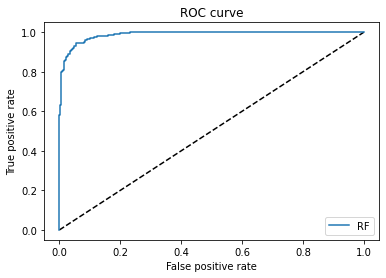

In [130]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [131]:
print('Timestamp of min value :' + ' ' + str(x_validate.index.min()), '\nTimestamp of max value :' + ' ' + str(x_validate.index.max()))

Timestamp of min value : 2011-11-04 14:36:38.114000 
Timestamp of max value : 2012-05-22 19:30:47.148000


### Meta-label 

These are the results of the model with meta-labeling for size

#### Performance Metrics

In [132]:
y_pred_rf = rf.predict_proba(x_validate)[:, 1]
y_pred = rf.predict(x_validate)

fpr_rf, tpr_rf, _ = sk.metrics.roc_curve(y_validate, y_pred_rf)

print(sk.metrics.classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.99      0.80      2084
           1       0.49      0.02      0.05      1013

    accuracy                           0.67      3097
   macro avg       0.58      0.51      0.42      3097
weighted avg       0.61      0.67      0.56      3097



#### Confusion Matrix

In [133]:
print(sk.metrics.confusion_matrix(y_validate, y_pred))

[[2058   26]
 [ 988   25]]


#### Accuracy

In [134]:
print(sk.metrics.accuracy_score(y_validate, y_pred))

0.6725863739102357


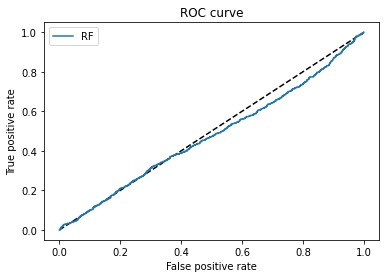

In [135]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [136]:
print('x_validate_min :' + ' ' + str(x_validate.index.min()), '\nx_validate_max :' + ' ' + str(x_validate.index.max()))

x_validate_min : 2011-11-04 14:36:38.114000 
x_validate_max : 2012-05-22 19:30:47.148000


In [137]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']
print(labels)

                              ret      trgt  bin  side
2011-09-23 13:09:25.468  0.005578  0.005339    1  -1.0
2011-09-23 14:29:06.110  0.007440  0.005153    1  -1.0
2011-09-23 15:17:05.382 -0.000371  0.005324    0  -1.0
2011-09-23 15:25:00.710 -0.002452  0.005800    0  -1.0
2011-09-23 15:35:18.697  0.000097  0.005991    0  -1.0
...                           ...       ...  ...   ...
2012-05-22 18:30:49.621  0.006796  0.006688    1   1.0
2012-05-22 18:52:39.135  0.008615  0.006563    1   1.0
2012-05-22 19:14:12.957  0.008026  0.006453    1   1.0
2012-05-22 19:24:34.124  0.006452  0.006444    1   1.0
2012-05-22 19:30:47.148  0.007513  0.006548    1   1.0

[4423 rows x 4 columns]


Set the time period for primary forecast

In [139]:
start = primary_forecast.index.get_loc('2011-09-23 13:09:25.468')
end = primary_forecast.index.get_loc('2012-05-22 19:30:47.148') + 1

In [140]:
subset_prim = primary_forecast[start:end]

### Performance Metrics

In [141]:
actual = subset_prim['actual']
pred = subset_prim['pred']
print(sk.metrics.classification_report(y_true=actual, y_pred=pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2867
           1       0.35      1.00      0.52      1556

    accuracy                           0.35      4423
   macro avg       0.18      0.50      0.26      4423
weighted avg       0.12      0.35      0.18      4423



#### Confusion Matrix

In [142]:
print(sk.metrics.confusion_matrix(actual, pred))

[[   0 2867]
 [   0 1556]]


#### Accuracy

In [143]:
print(sk.metrics.accuracy_score(actual, pred))

0.3517974225638707


## Feature Importance

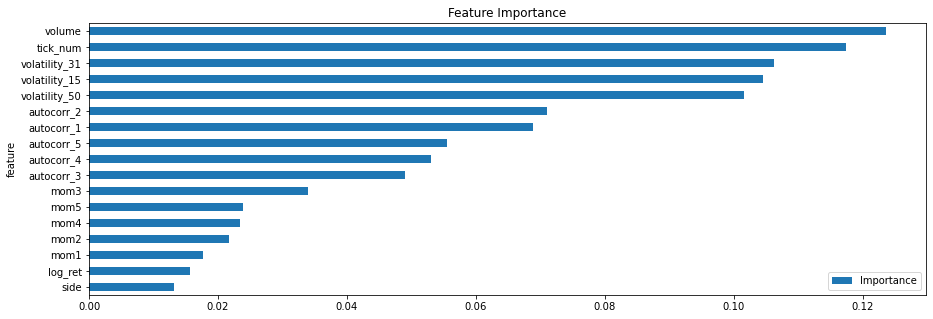

In [144]:
title = 'Feature Importance'
figsize = (15,5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})
feat_imp['feature'] = x.columns
feat_imp.sort_values(by="Importance", ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)

### Perfromance Sheet

In [145]:
def get_daily_returns(intraday_returns):
        """
        Daily returns for pyfolio
        """
        cum_rets = ((intraday_returns + 1).cumprod())
        # Downsample to daily
        daily_rets = cum_rets.resample('B').last()
        # Forward fill, Percent change, Drop NaN
        daily_rets = daily_rets.ffill().pct_change().dropna()
        return daily_rets

In [146]:
valid_dates = x_validate.index
base_rets = labels.loc[valid_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

In [147]:
# Set up the function to extract the KPI's from pyfolio
perf_func = pf.timeseries.perf_stats

In [148]:
# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets, 
                        factor_returns=None, 
                        positions=None,
                        transactions=None,
                        turnover_denom="AGB")

perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])
pf.show_perf_stats(primary_model_rets)

Start date,2011-11-07
End date,2012-05-22
Total months,6
,Backtest
Annual return,309.1%
Cumulative returns,121.2%
Annual volatility,145.9%
Sharpe ratio,1.65
Calmar ratio,3.79
Stability,0.00
Max drawdown,-81.6%


### With Meta-labeling

In [149]:
meta_returns = labels.loc[valid_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

# Save KPIs in a dataframe
erf_stats_all = perf_func(returns=daily_meta_rets, 
                        factor_returns=None, 
                        positions=None,
                        transactions=None,
                        turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

pf.show_perf_stats(daily_meta_rets)

Start date,2011-11-07
End date,2012-05-22
Total months,6
,Backtest
Annual return,6.7%
Cumulative returns,3.7%
Annual volatility,8.6%
Sharpe ratio,0.80
Calmar ratio,1.33
Stability,0.00
Max drawdown,-5.0%


### Out of Sample Test

#### Meta Model Metrics

In [150]:
# extract out of sample data
x_oos = x
y_oos = y

# Performance Metrics
y_pred_rf = rf.predict_proba(x_oos)[:, 1]
y_pred = rf.predict(x_oos)
fpr_rf, tpr_rf, _ = sk.metrics.roc_curve(y_oos, y_pred_rf)
print(sk.metrics.classification_report(y_oos, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.96      0.83      2867
           1       0.82      0.33      0.47      1556

    accuracy                           0.74      4423
   macro avg       0.77      0.65      0.65      4423
weighted avg       0.76      0.74      0.70      4423



#### Confusion Matrix

In [151]:
print(sk.metrics.confusion_matrix(y_oos, y_pred))

[[2750  117]
 [1038  518]]


#### Accuracy

In [152]:
print(sk.metrics.accuracy_score(y_oos, y_pred))

0.7388650237395433


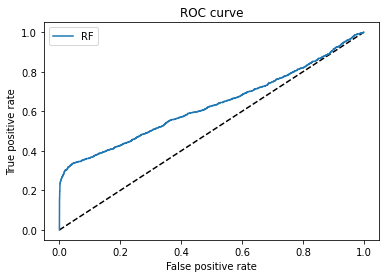

In [153]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()